<a href="https://colab.research.google.com/github/champ-rtu/M5_F/blob/main/M5_Forcasting_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# **Preprocessing&Feature Engineering**

1. handled with missing value 
2. melt the sale dataset (tranform wide dataset to long dataset)
3. create lag feature 
4. merge three dataset together

In [2]:
# Memory reduction helper function:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns: #columns
        col_type = df[col].dtypes
        if col_type in numerics: #numerics
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
#read sale file by pandas
df_sale = pd.read_csv('/content/drive/MyDrive/sales_train_validation.csv')
#apply reduce memory function
df_sale = reduce_mem_usage(df_sale)

Mem. usage decreased to 95.00 Mb (78.7% reduction)


In [31]:
#identify missing value in sale dataset
df_sale.isnull().sum()

id          0
item_id     0
dept_id     0
cat_id      0
store_id    0
           ..
d_1909      0
d_1910      0
d_1911      0
d_1912      0
d_1913      0
Length: 1919, dtype: int64

In [4]:
#melt the sales dataset
df = df_sale.melt(id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
                  var_name='d',
                  value_name='Sales')

In [5]:
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,Sales
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


In [33]:
#read sale file by pandas
df_cal = pd.read_csv('/content/drive/MyDrive/calendar.csv')
#apply reduce memory function
df_cal = reduce_mem_usage(df_cal)

Mem. usage decreased to  0.12 Mb (41.9% reduction)


In [34]:
#identify missing value in calendar data
df_cal.isnull().sum()

date               0
wm_yr_wk           0
weekday            0
wday               0
month              0
year               0
d                  0
event_name_1    1807
event_type_1    1807
event_name_2    1964
event_type_2    1964
snap_CA            0
snap_TX            0
snap_WI            0
dtype: int64

In [49]:
#change datatype to datetime 
df_cal['date'] = pd.to_datetime(df_cal['date'], format='%Y-%m-%d')
df_cal['year'] = df_cal['date'].dt.year
df_cal['month'] = df_cal['date'].dt.month
df_cal['week'] = df_cal['date'].dt.week
df_cal['day'] = df_cal['date'].dt.day

#change null value in event name1,2 and event type1,2 by 0
df_cal['event_name_1'][df_cal['event_name_1'].isnull()] = 0
df_cal['event_name_2'][df_cal['event_name_2'].isnull()] = 0
df_cal['event_type_1'][df_cal['event_type_1'].isnull()] = 0
df_cal['event_type_2'][df_cal['event_type_2'].isnull()] = 0

#Create event num column for indicate that day have event or not
df_cal['event_num'] = pd.Series()
df_cal['event_num'][ df_cal['event_type_1'] != 0] = 1
df_cal['event_num'][df_cal['event_type_2'] != 0] == 2 
df_cal['event_num'][df_cal['event_num'].isnull()] = 0

#Create weekend column 
df_cal['weekend'] = pd.Series()
df_cal['weekend'] [(df_cal['weekday'] == 'Saturday') | (df_cal['weekday'] == 'Sunday')] = 1
df_cal['weekend'][df_cal['weekend'].isnull()] = 0
df_cal.drop(['event_type_2','event_name_2','event_name_1','event_type_1','weekday'], axis=1, inplace=True)
df_cal.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy o

,date,wm_yr_wk,wday,month,year,d,snap_CA,snap_TX,snap_WI,week,day,event_num,weekend
0,2011-01-29,11101,1,1,2011,d_1,0,0,0,4,29,0.0,1.0
1,2011-01-30,11101,2,1,2011,d_2,0,0,0,4,30,0.0,1.0
2,2011-01-31,11101,3,1,2011,d_3,0,0,0,5,31,0.0,0.0
3,2011-02-01,11101,4,2,2011,d_4,1,1,0,5,1,0.0,0.0
4,2011-02-02,11101,5,2,2011,d_5,1,0,1,5,2,0.0,0.0


In [8]:
#merge sale data with calendar data
df_merge = df.merge(df_cal, on ='d')

In [9]:
df_merge.shape

(58327370, 20)

In [10]:
# apply lag feature by choose 28,35,42,49,56
lags = [28,35,42,49,56]
for i in tqdm(lags):
  df_merge['lag_'+str(i)] = df_merge[['id', 'Sales']].groupby('id')['Sales'].shift(i)

100%|██████████| 5/5 [01:03<00:00, 12.79s/it]


In [11]:
df_merge = reduce_mem_usage(df_merge)

Mem. usage decreased to 5506.91 Mb (41.1% reduction)


In [12]:
#change the value in d column for d_1 to 1
df_merge['d'] = df_merge['d'].apply(lambda x: int(x.split('_')[1]))


In [13]:
#due to this dataset is very big dataset. So the data from day 1 to 1200 was cut
df_merge = df_merge[df_merge['d']> 1200]

In [14]:
df_merge.shape

(21739370, 25)

In [15]:
#read price data 
df_price = pd.read_csv('/content/drive/MyDrive/sell_prices.csv')
#reduce memory usage
df_price= reduce_mem_usage(df_price)

Mem. usage decreased to 130.48 Mb (37.5% reduction)


In [36]:
#merge sale, calendar and price dataset together
df_ = df_merge.merge(df_price, on=['store_id', 'item_id', 'wm_yr_wk'])
df_.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,Sales,date,wm_yr_wk,wday,month,year,snap_CA,snap_TX,snap_WI,week,day,event_num,weekend,lag_28,lag_35,lag_42,lag_49,lag_56,sell_price
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1201,0,2014-05-13,11415,4,5,2014,0,1,0,20,13,0.0,0.0,0.0,1.0,0.0,0.0,1.0,8.257812
1,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1202,0,2014-05-14,11415,5,5,2014,0,0,1,20,14,0.0,0.0,0.0,1.0,0.0,1.0,0.0,8.257812
2,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1203,0,2014-05-15,11415,6,5,2014,0,1,1,20,15,0.0,0.0,1.0,0.0,0.0,0.0,1.0,8.257812
3,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1204,0,2014-05-16,11415,7,5,2014,0,0,0,20,16,0.0,0.0,1.0,1.0,0.0,0.0,1.0,8.257812
4,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1201,0,2014-05-13,11415,4,5,2014,0,1,0,20,13,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.970703


In [37]:
#drop id, dept_id, cat_id, state_id and date column
df_.drop(['id','dept_id','cat_id','state_id','date'],axis = 1, inplace = True)

In [38]:
df_.head()

,item_id,store_id,d,Sales,wm_yr_wk,wday,month,year,snap_CA,snap_TX,snap_WI,week,day,event_num,weekend,lag_28,lag_35,lag_42,lag_49,lag_56,sell_price
0,HOBBIES_1_001,CA_1,1201,0,11415,4,5,2014,0,1,0,20,13,0.0,0.0,0.0,1.0,0.0,0.0,1.0,8.257812
1,HOBBIES_1_001,CA_1,1202,0,11415,5,5,2014,0,0,1,20,14,0.0,0.0,0.0,1.0,0.0,1.0,0.0,8.257812
2,HOBBIES_1_001,CA_1,1203,0,11415,6,5,2014,0,1,1,20,15,0.0,0.0,1.0,0.0,0.0,0.0,1.0,8.257812
3,HOBBIES_1_001,CA_1,1204,0,11415,7,5,2014,0,0,0,20,16,0.0,0.0,1.0,1.0,0.0,0.0,1.0,8.257812
4,HOBBIES_1_002,CA_1,1201,0,11415,4,5,2014,0,1,0,20,13,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.970703


In [39]:
reduce_mem_usage(df_)

Mem. usage decreased to 1115.28 Mb (9.8% reduction)


,item_id,store_id,d,Sales,wm_yr_wk,wday,month,year,snap_CA,snap_TX,snap_WI,week,day,event_num,weekend,lag_28,lag_35,lag_42,lag_49,lag_56,sell_price
0,HOBBIES_1_001,CA_1,1201,0,11415,4,5,2014,0,1,0,20,13,0.0,0.0,0.0,1.0,0.0,0.0,1.0,8.257812
1,HOBBIES_1_001,CA_1,1202,0,11415,5,5,2014,0,0,1,20,14,0.0,0.0,0.0,1.0,0.0,1.0,0.0,8.257812
2,HOBBIES_1_001,CA_1,1203,0,11415,6,5,2014,0,1,1,20,15,0.0,0.0,1.0,0.0,0.0,0.0,1.0,8.257812
3,HOBBIES_1_001,CA_1,1204,0,11415,7,5,2014,0,0,0,20,16,0.0,0.0,1.0,1.0,0.0,0.0,1.0,8.257812
4,HOBBIES_1_002,CA_1,1201,0,11415,4,5,2014,0,1,0,20,13,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.970703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21262854,FOODS_3_825,WI_3,1913,0,11613,2,4,2016,0,0,0,16,24,0.0,1.0,1.0,0.0,1.0,2.0,0.0,3.980469
21262855,FOODS_3_826,WI_3,1912,1,11613,1,4,2016,0,0,0,16,23,0.0,1.0,2.0,1.0,1.0,2.0,0.0,1.280273
21262856,FOODS_3_826,WI_3,1913,3,11613,2,4,2016,0,0,0,16,24,0.0,1.0,4.0,1.0,3.0,2.0,0.0,1.280273
21262857,FOODS_3_827,WI_3,1912,0,11613,1,4,2016,0,0,0,16,23,0.0,1.0,0.0,1.0,2.0,3.0,4.0,1.000000


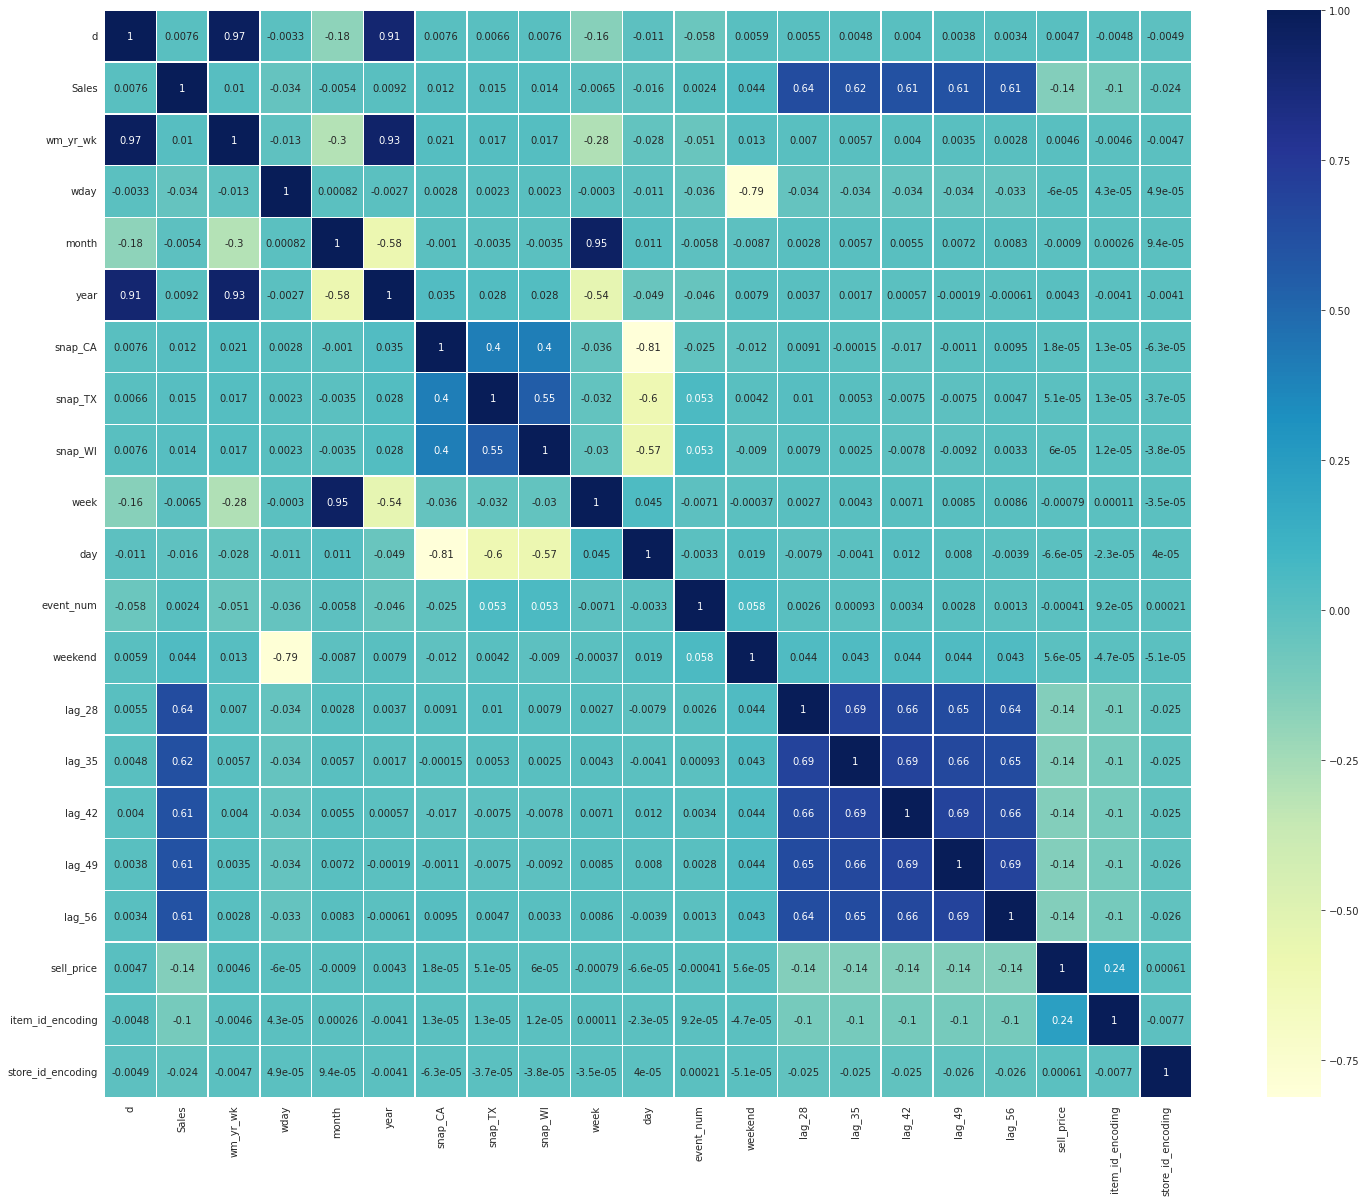

In [30]:
#Heatmap and correlation (Check correlation between features)
with sns.axes_style("white"):
    plt.figure(figsize=(27,20))
    sns.heatmap(df_.corr(),annot=True,linewidths=.5, cmap="YlGnBu",square=True)

# **Modeling Method**
After Preprocessing and Feature Engineering method the dataset was applied 3 ML algorithm. Before apply ML algorithm, categorical data have to encode to numerical variable. 
1. DecisionTree Regressor
2. KNN Regressor
3. Linear Regression

In [24]:
#import the necessary library for built modeling, encoding and model evaluation
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error


In [35]:
#create function for convert non-numerical data to numerical data by use Label encoder
def tranform(dataset):
    for column in dataset.columns:
        if dataset[column].dtypes == type(object):
            le = LabelEncoder()
            dataset[column]=le.fit_transform(dataset[column])
    return dataset

In [40]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21262859 entries, 0 to 21262858
Data columns (total 21 columns):
 #   Column      Dtype  
---  ------      -----  
 0   item_id     object 
 1   store_id    object 
 2   d           int16  
 3   Sales       int16  
 4   wm_yr_wk    int16  
 5   wday        int8   
 6   month       int8   
 7   year        int16  
 8   snap_CA     int8   
 9   snap_TX     int8   
 10  snap_WI     int8   
 11  week        int8   
 12  day         int8   
 13  event_num   float16
 14  weekend     float16
 15  lag_28      float16
 16  lag_35      float16
 17  lag_42      float16
 18  lag_49      float16
 19  lag_56      float16
 20  sell_price  float16
dtypes: float16(8), int16(4), int8(7), object(2)
memory usage: 1.1+ GB


In [41]:
#apply encoding function for covert non-numeriacal to numerical
df_ = tranform(df_)

In [43]:
df_.head()

,item_id,store_id,d,Sales,wm_yr_wk,wday,month,year,snap_CA,snap_TX,snap_WI,week,day,event_num,weekend,lag_28,lag_35,lag_42,lag_49,lag_56,sell_price
0,1437,0,1201,0,11415,4,5,2014,0,1,0,20,13,0.0,0.0,0.0,1.0,0.0,0.0,1.0,8.257812
1,1437,0,1202,0,11415,5,5,2014,0,0,1,20,14,0.0,0.0,0.0,1.0,0.0,1.0,0.0,8.257812
2,1437,0,1203,0,11415,6,5,2014,0,1,1,20,15,0.0,0.0,1.0,0.0,0.0,0.0,1.0,8.257812
3,1437,0,1204,0,11415,7,5,2014,0,0,0,20,16,0.0,0.0,1.0,1.0,0.0,0.0,1.0,8.257812
4,1438,0,1201,0,11415,4,5,2014,0,1,0,20,13,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.970703


In [23]:
#split the trainning data and test data by the objective is forecasting sales 28 so test set is the data of last 28 day
X_train = df_[df_["d"] < 1886].drop(columns=["Sales"])
X_val = df_[df_["d"].between(1886, 1913)].drop(columns=["Sales"])
X_test = df_[df_["d"] > 1913].drop(columns=["Sales"])

#Create the label data
y_train = df_[df_["d"] < 1886]["Sales"]
y_val = df_[df_["d"].between(1886, 1913)]["Sales"]

In [25]:
#convert the following column to category type
cols = ['wday','month','year','snap_CA','snap_TX','snap_WI','week','day','event_num','weekend']

for col in cols:
    X_train[col] = X_train[col].astype('category')
    X_val[col] = X_val[col].astype('category')
    

In [26]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20409139 entries, 0 to 20561583
Data columns (total 20 columns):
 #   Column             Dtype   
---  ------             -----   
 0   d                  int16   
 1   wm_yr_wk           int16   
 2   wday               category
 3   month              category
 4   year               category
 5   snap_CA            category
 6   snap_TX            category
 7   snap_WI            category
 8   week               category
 9   day                category
 10  event_num          category
 11  weekend            category
 12  lag_28             float16 
 13  lag_35             float16 
 14  lag_42             float16 
 15  lag_49             float16 
 16  lag_56             float16 
 17  sell_price         float16 
 18  item_id_encoding   int16   
 19  store_id_encoding  int8    
dtypes: category(10), float16(6), int16(3), int8(1)
memory usage: 720.2 MB


**Apply DecisionTree Regressor model without hyperparameter tunning**

In [36]:
#create DecisionTree Regressor model
dt = DecisionTreeRegressor()
#train the model
dt.fit(X_train, y_train)


DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [37]:
#predict the sales from X_val
pred = dt.predict(X_val)
#Model Evaluation by Root mean square error(RMSE)
mse = mean_squared_error(pred, y_val)
rmse = np.sqrt(mse)
print(rmse)

3.9255808281221554


**Apply DecisionTree Regressor model with hyperparameter tunning by GridSearch**

In [ ]:
#create dict with use with hyper parameter tunning 
param_grid = {"criterion": ["mse", "mae"],
              "min_samples_split": [10, 20, 40],
              "max_depth": [2, 6, 8],
              "min_samples_leaf": [20, 40, 100],
              "max_leaf_nodes": [5, 20, 100],
              }

#Apply GridSearchCV for hyperparameter tunning
grid_cv_dt = GridSearchCV(dt, param_grid )
#Trainning the train data
grid_cv_dt.fit(X,y)

In [ ]:
#predict the sales from X_val
pred_ = grid_cv_dt.predict(X_val)
#Model Evaluation by Root mean square error(RMSE)
mse = mean_squared_error(pred_, y_val)
rmse = np.sqrt(mse)
print(rmse)

**Apply KNN regressor model without hyperparameter tunning**

In [38]:
#create KNeighborsRegressor model
knn = KNeighborsRegressor()
#train dataset
knn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [39]:
#predict the sales from X_val
pred_knn = knn.predict(X_val)
#Evaluation KNeighborsRegressor model
mse = mean_squared_error(pred_knn, y_val)
rmse = np.sqrt(mse)
print(rmse)

2.4502025289996423


**Apply KNN regressor model with hyperparameter tunning by Grid Search**

In [ ]:
#create dict with use with hyper parameter tunning 
param = {
   'n_neighbors' : [5,10,20,50],
    'weights' : ['uniform', 'distance']}

In [ ]:
#Apply GridSearchCV for hyperparameter tunning
grid = GridSearchCV(knn, param, n_jobs=-1)
grid.fit(X_train, y_train)

In [ ]:
#Predict after tunning parameter
pred_knn_ = grid.predict(X_val)
#Model Evaluation by Root mean square error(RMSE)
mse = mean_squared_error(pred_knn_, y_val)
rmse = np.sqrt(mse)
print(rmse)

**Apply Linear Regression**

In [27]:
#built LinearRegression model
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [28]:
pred_lr = lr.predict(X_val)
mse = mean_squared_error(pred_lr, y_val)
rmse = np.sqrt(mse)
print(rmse)

2.271387917405504
